<a href="https://colab.research.google.com/github/mmurker/MachineLearning-ArtificialNeuralNetworks-MATLAB/blob/master/GRU_ve_MLP_Derin_%C3%96%C4%9Frenme_Modelleri_ile_Ger%C3%A7ek_Zamanl%C4%B1_%C3%9Cretim_ve_T%C3%BCketim_Verilerini_Kullanarak_G%C3%BCn_%C3%96ncesi_Piyasa_Takas_Fiyat%C2%A0Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#HTTP isteği oluşturmak için requests modülünü içe aktaralım.
#Şeffaflık platformundan alacağımız veriler için EPİAŞ Şeffaflık Web Servis Kullanım Kılavuzunun detaylarını incelemenizi tavsiye ederim.
#Web Servis Kullanım Kılavuzu Link: https://seffaflik.epias.com.tr/documentation/web-service-user-guide

import requests

# Kullanıcı bilgileri (değiştirin) EPİAŞ Şeffaflık platformunda oluşturduğumuz kullanıcı adı ve şifre ile sisteme giriş yapmış olacağız.

username = "Şeffaflık Platformunda Kayıtlı Olan Mail Adresiniz"
password = "Şeffaflık Platformunda Kayıtlı Olan Şifreniz"

# 1. TGT Al EPİAŞ Web Servis Kullanım Kılavuzunda gösterildiği gibi TGT almış olacağız.
#Her yeni kod dizininde tekrar etmeniz gerekmez, yalnızca bir kez almak yeterli olacaktır.

auth_url = "https://giris.epias.com.tr/cas/v1/tickets"
headers_auth = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "text/plain"
}
data_auth = {
    "username": username,
    "password": password
}

auth_response = requests.post(auth_url, headers=headers_auth, data=data_auth,timeout=10)

if auth_response.status_code == 201:
    tgt = auth_response.text.strip()
    print("✅ TGT alındı:\n", tgt)
else:
    print("❌ TGT alınamadı. Hata:", auth_response.status_code)
    print(auth_response.text)
    raise SystemExit

# 2. Veri İsteği: Gerçek Zamanlı Üretim değerlerini sistemden çekmek için istek yapmış olacağız.
#Veri aralığı için tarihi istediğiniz format ve aralıkta ayarlayabilirsiniz.

data_url = "https://seffaflik.epias.com.tr/electricity-service/v1/generation/data/realtime-generation"
headers_data = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "TGT": tgt
}
payload = {
    "startDate": "2025-01-01T00:00:00.000+03:00",
    "endDate": "2025-03-30T23:00:00.000+03:00"
}

#EPİAŞ'ta istek yapılabilecek veri 3 ay ile sınırlıdır bu nedenle bir sonraki adımda istediğimiz aralık için başka bir kod satırı oluşturacağız.
#Burada sistemin çalışıp çalışmadığını test ettik.

data_response = requests.post(data_url, headers=headers_data, json=payload)

if data_response.status_code == 200:
    data = data_response.json()
    print("✅ Veri başarıyla çekildi!")
    print(data)
else:
    print("❌ Veri alınamadı. Hata:", data_response.status_code)
    print(data_response.text)

✅ TGT alındı:
 TGT-711990-Xpm0DuRFLgXkMf4PaOFqxkfcE-9jDLO9dOihw58GkRTJXw2k9C1cj-35d4CA2bhLz4Y-cas-65b44f7858-zvlkr
✅ Veri başarıyla çekildi!
{'items': [{'date': '2025-01-01T00:00:00+03:00', 'hour': '00:00', 'total': 32663.63, 'naturalGas': 6062.69, 'dammedHydro': 5510.01, 'lignite': 4974.52, 'river': 1644.69, 'importCoal': 9733.97, 'wind': 2281.27, 'sun': 0, 'fueloil': 81.51, 'geothermal': 1347.07, 'asphaltiteCoal': 81.69, 'blackCoal': 553.59, 'biomass': 972.71, 'naphta': 0, 'lng': 0, 'importExport': -656.47, 'wasteheat': 76.38}, {'date': '2025-01-01T01:00:00+03:00', 'hour': '01:00', 'total': 31147.31, 'naturalGas': 5708.52, 'dammedHydro': 4552.08, 'lignite': 4858.9, 'river': 1420.32, 'importCoal': 10074.39, 'wind': 2053.07, 'sun': 0, 'fueloil': 80.01, 'geothermal': 1346.87, 'asphaltiteCoal': 81.69, 'blackCoal': 546.18, 'biomass': 972.21, 'naphta': 0, 'lng': 0, 'importExport': -624.35, 'wasteheat': 77.42}, {'date': '2025-01-01T02:00:00+03:00', 'hour': '02:00', 'total': 29622.41, 'natur

In [2]:
#İstediğimiz tarih aralığını 3'er aylık(90 gün) periyotlara bölen fonksiyonu tanımlayalım. Çünkü genellikle veri analizi için 90 günü aşan datalara ihtiyaç duyacağız.
#Aldığı her bir 90 günlük kaydı all_data içerisinde saklayacaktır.

from datetime import datetime, timedelta
import pandas as pd

def fetch_epias_data(start_date, end_date, url, headers, payload_template):
    def daterange(start, end, delta):
        current = start
        while current < end:
            yield current, min(current + delta, end)
            current += delta

    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    three_months = timedelta(days=90)

    all_data = []

    for period_start, period_end in daterange(start, end, three_months):
        payload = payload_template.copy()
        payload["startDate"] = period_start.strftime("%Y-%m-%dT%H:%M:%S.000+03:00")
        payload["endDate"] = period_end.strftime("%Y-%m-%dT%H:%M:%S.000+03:00")

        response = requests.post(url, json=payload, headers=headers)

        if response.status_code == 200:
            data = response.json()
            items = data.get("items", [])
            all_data.extend(items)
        else:
            print(f"API Error for period {period_start} to {period_end}: {response.status_code}")

    df = pd.DataFrame(all_data)
    return df

In [3]:
#Başlangıç ve bitiş tarihlerini belirleyelim.
#yyyy-aa-gg olarak vereceğimiz format (payload_template içinde belirtilmiştir) yazdığımız fonksiyon içerisinde istek için web servise uygun hale gelecektir.
#Belirlediğimiz tarih aralığını 90 gün kuralı için fetch_epias_data fonksiyonuna göndereceğiz.

#Gerçek zamanlı üretim verilerini çekelim, fiyatlar gerçekleşen üretimler ile ilişkili olacaktır.

start_date = "2024-01-01"
end_date = "2025-08-31"
url = "https://seffaflik.epias.com.tr/electricity-service/v1/generation/data/realtime-generation"

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "TGT": tgt
}

payload_template = {
    "startDate": "%Y-%m-%dT%H:%M:%S.000+03:00",
    "endDate": "%Y-%m-%dT%H:%M:%S.000+03:00"
}

df = fetch_epias_data(start_date, end_date, url, headers, payload_template)
print(df.head()) #head ile ilk 5 satırı görmek istedik elde etmek istediğimiz tüm listelerden sonra tamamını print ile görüntüleyebiliriz.

#Aynı şekilde ilgili tarih aralığı için gerçek zamanlı tüketim verilerini çekelim, fiyatlar gerçekleşen tüketim ile ilişkili olacaktır.

start_date = "2024-01-01"
end_date = "2025-08-31"
url = "https://seffaflik.epias.com.tr/electricity-service/v1/consumption/data/realtime-consumption"

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "TGT": tgt
}

payload_template = {
    "startDate": "%Y-%m-%dT%H:%M:%S.000+03:00",
    "endDate": "%Y-%m-%dT%H:%M:%S.000+03:00"
}

df_cons = fetch_epias_data(start_date, end_date, url, headers, payload_template)
print(df_cons.head())

#Aynı şekilde ilgili tarih aralığı için piyasa takas fiyatını çekelim.

start_date = "2024-01-01"
end_date = "2025-08-31"
url = "https://seffaflik.epias.com.tr/electricity-service/v1/markets/dam/data/mcp"

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "TGT": tgt
}

payload_template = {
    "startDate": "%Y-%m-%dT%H:%M:%S.000+03:00",
    "endDate": "%Y-%m-%dT%H:%M:%S.000+03:00"
}

df_ptf = fetch_epias_data(start_date, end_date, url, headers, payload_template)
print(df_ptf.head())

                        date   hour     total  naturalGas  dammedHydro  \
0  2024-01-01T00:00:00+03:00  00:00  28876.95     2316.70      8307.83   
1  2024-01-01T01:00:00+03:00  01:00  27658.01     2129.89      7353.48   
2  2024-01-01T02:00:00+03:00  02:00  26286.14     1842.05      5686.84   
3  2024-01-01T03:00:00+03:00  03:00  25301.83     1882.47      4940.00   
4  2024-01-01T04:00:00+03:00  04:00  24692.58     1929.15      4646.57   

   lignite    river  importCoal     wind   sun  fueloil  geothermal  \
0  5389.08  1651.16     6676.23  1081.98  0.01    86.87     1304.66   
1  5090.44  1656.39     6685.98  1303.25  0.01    86.07     1304.41   
2  5141.90  1532.78     6910.61  1734.21  0.01    84.88     1308.64   
3  5051.17  1454.29     6556.29  1978.15  0.01    83.08     1309.39   
4  4739.44  1415.28     6409.74  2130.39  0.01    83.08     1310.80   

   asphaltiteCoal  blackCoal  biomass  naphta  lng  importExport  wasteheat  
0          130.27     607.18   992.87       0    0

In [4]:
#Şimdi istediğimiz aralıkta eşit satır sayısına sahip üç ayrı dataframe görmek istiyoruz.
#Bu örnekte 14760 satırdan oluşan üç ayrı datasetimiz olduğunu teyit ettik.
#Veri setinin tamamı için csv ya da xlsx formatında içe aktarım yapabilirsiniz.

print(df_ptf) #saatlik piyasa takas fiyatı
print(df_cons) #gerçek zamanlı saatlik tüketim verisi
print(df) #gerçek zamanlı saatlik üretim verileri

                            date   hour    price  priceUsd  priceEur
0      2024-01-01T00:00:00+03:00  00:00  1299.98     44.16     39.91
1      2024-01-01T01:00:00+03:00  01:00  1299.98     44.16     39.91
2      2024-01-01T02:00:00+03:00  02:00  1248.54     42.41     38.33
3      2024-01-01T03:00:00+03:00  03:00  1299.98     44.16     39.91
4      2024-01-01T04:00:00+03:00  04:00  1200.00     40.76     36.84
...                          ...    ...      ...       ...       ...
14755  2025-08-31T19:00:00+03:00  19:00  3400.00     83.04     71.15
14756  2025-08-31T20:00:00+03:00  20:00  3400.00     83.04     71.15
14757  2025-08-31T21:00:00+03:00  21:00  3400.00     83.04     71.15
14758  2025-08-31T22:00:00+03:00  22:00  3400.00     83.04     71.15
14759  2025-08-31T23:00:00+03:00  23:00  3240.00     79.13     67.80

[14760 rows x 5 columns]
                            date   time  consumption
0      2024-01-01T00:00:00+03:00  00:00     28929.45
1      2024-01-01T01:00:00+03:00  01:00 

In [5]:
#Şimdi verisetimizi birleştirelim.
#date ve hour değişkenleri ortak olduğu için df_ptf'den yalnızca PTF(Price) sütununu almayı tercih edeceğiz.
#naptha ve lng sütunlarının tüm saatlerde 0 olması modele katkı yapmayacağından veri setinden çıkartacağız.
#Ayrıca total verisini de kullanmayacağımız için veri setinden çıkartacağız.

df["consumption"] = df_cons["consumption"]
df["price"] = df_ptf["price"]
df.drop(columns=["total","naphta","lng"], inplace=True)
print(df.head())

                        date   hour  naturalGas  dammedHydro  lignite  \
0  2024-01-01T00:00:00+03:00  00:00     2316.70      8307.83  5389.08   
1  2024-01-01T01:00:00+03:00  01:00     2129.89      7353.48  5090.44   
2  2024-01-01T02:00:00+03:00  02:00     1842.05      5686.84  5141.90   
3  2024-01-01T03:00:00+03:00  03:00     1882.47      4940.00  5051.17   
4  2024-01-01T04:00:00+03:00  04:00     1929.15      4646.57  4739.44   

     river  importCoal     wind   sun  fueloil  geothermal  asphaltiteCoal  \
0  1651.16     6676.23  1081.98  0.01    86.87     1304.66          130.27   
1  1656.39     6685.98  1303.25  0.01    86.07     1304.41          132.48   
2  1532.78     6910.61  1734.21  0.01    84.88     1308.64          134.68   
3  1454.29     6556.29  1978.15  0.01    83.08     1309.39          130.27   
4  1415.28     6409.74  2130.39  0.01    83.08     1310.80          132.48   

   blackCoal  biomass  importExport  wasteheat  consumption    price  
0     607.18   992.87

In [6]:
#Eksik veri olmadığını bilmek isteyeceğiz; bu nedenle kontrol etmeliyiz.
#Eksik (Null) Değerleri Tespit Etme
# Eksik değerleri say

missing_values = df.isnull().sum()

# Sadece eksik değeri olan sütunları göster
missing_values[missing_values > 0]

,0


In [7]:
#2. Boş veya Geçersiz Değerler (örneğin '')
# Boş string ("") veya sadece boşluk içeren hücrelerin sayısını bul

empty_string_counts = (df.map(lambda x: str(x).strip() == '')).sum()
empty_string_counts[empty_string_counts > 0]

,0


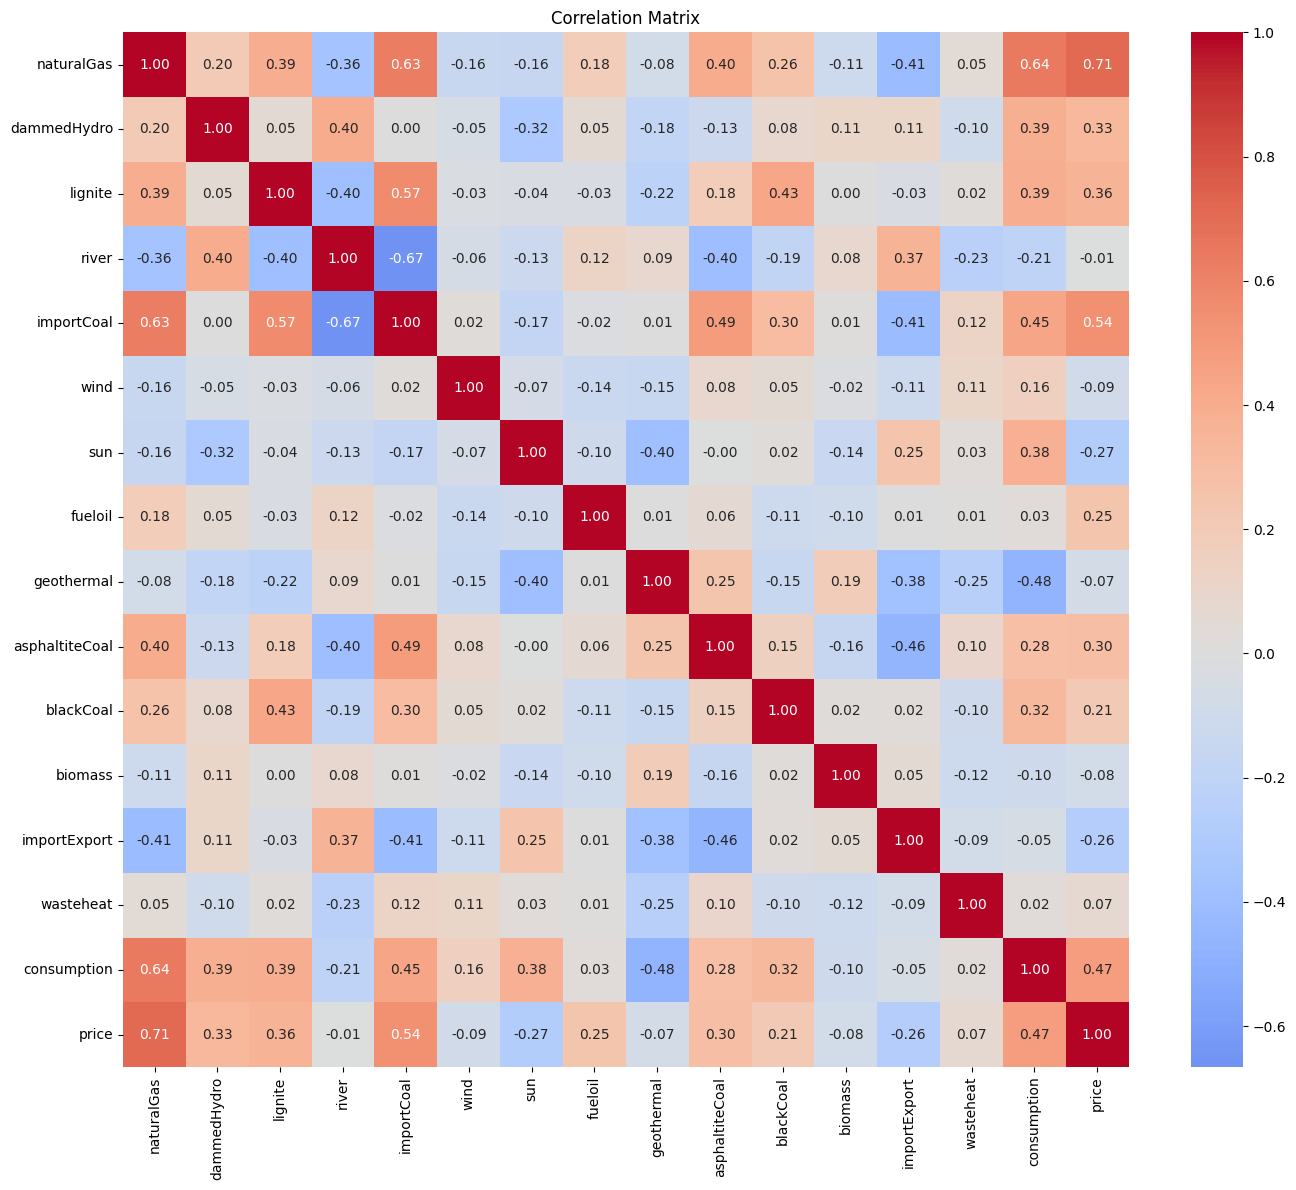

In [8]:
#Burada aykırı olan verileri tespit etmek isteyebilirdik. Ancak bu veri seti için adımı uygulamayacağım çünkü; gerçekten bu aykırı değerler yeniden gerçekleşme olasılığına sahiptir ve kuracak olduğumuz modellerde bu verilerle karşılaşmalılar diye düşünüyorum.
#Örneğin elimizde kullanıcılar tarafından doldurulmuş bir anket datası olsaydı aykırı/eksik/yanlış/boş veriler için mutlaka ön işleme aşamalarını detaylı bir şekilde uygulardık.
#Literatürde gerçek hayatta karşılaşılan aykırı değerlerin düzgünleştirilmemesi ya da veri setinden çıkarılmaması genel olarak kabul edilebilirdir.
#Artık veri seti hazır. Şimdi tahmine başlamadan önce girdi setinin çıktı ile ilişkilerini ortaya çıkaralım.
#Amaçlarımız şu şekilde olacak:
#Veri setindeki bilgi kaybını minimize etmek, gereksiz tekrarı (multicollinearity) ortadan kaldırmak
#Aşırı öğrenmeyi (overfitting) azaltmak, daha genellenebilir bir model ortaya çıkartmak
#Kısaca modele aynı katkıyı sunacak, çoklu doğrusallık oluşturacak verileri korelasyon matrisi yardımı ile belirleyelim
#Nihai durumdan hangi veriler ile yola devam edeceğimize bakalım.

import seaborn as sns
import matplotlib.pyplot as plt

# Girdi ve çıktıyı içeren yeni bir DataFrame oluştur
df_corr = df.drop(columns=["date", "hour"])

# Korelasyon matrisi hesapla
corr_matrix = df_corr.corr()

# Görselleştirme
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

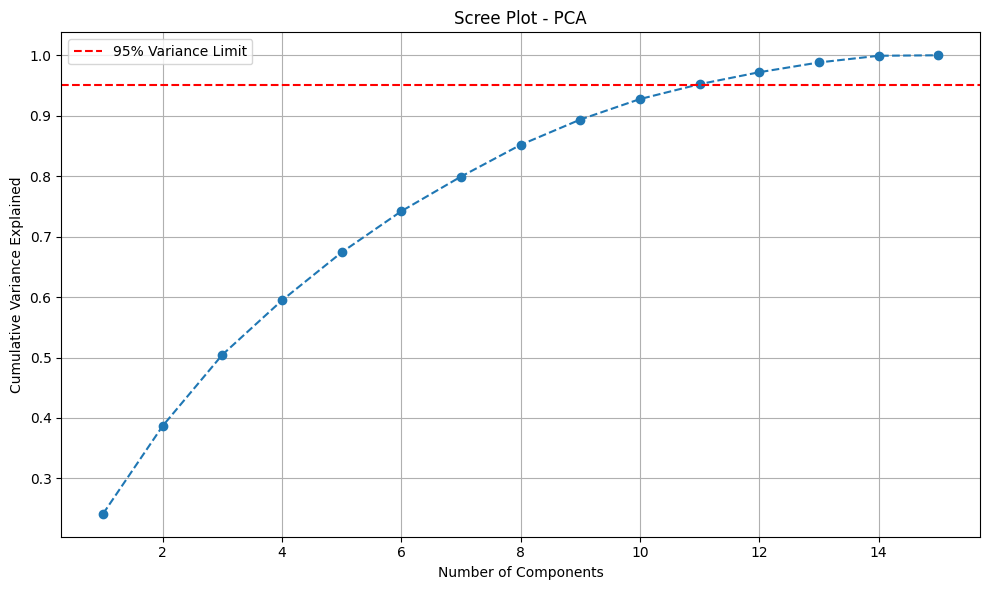

Variables that most affect the first 3 PCA components:
                     PC1       PC2       PC3
importCoal      0.457494  0.113858  0.043364
naturalGas      0.415634  0.007442  0.243037
river           0.366180  0.117172  0.359073
consumption     0.349355  0.385610  0.112759
lignite         0.340674  0.150470  0.087716
asphaltiteCoal  0.325652  0.251842  0.099979
importExport    0.248801  0.430624  0.013890
blackCoal       0.237688  0.179839  0.118264
wasteheat       0.090073  0.030431  0.298964
geothermal      0.079212  0.571527  0.136290


In [9]:
#Korelasyon matrisini incelediğimizde doğalgaz(naturalgas), ithal kömür(importCoal) ve barajlı(dammedHydro) kaynaklarının PTF(price) ile pozitif yüksek korelasyona sahip olduklarını görebiliriz.
#Uluslararası(importExport),biyokütle(biomass) ve atık ısı(wasteheat) kaynaklarının PTF ile düşük ya da negatif korelasyona sahip olduklarını söyleyebiliriz.
#Ayrıca importCoal ile lignite ve geothermal ile asphaltiteCoal kaynaklarının birbirleri ile yüksek korelasyona sahip olduklarını söyleyebiliriz.
#Biribiri ile yüksek ilişkiye sahip değişkenler genelllikle aynı katkıyı sunacaklarından yalnızca biri modele dahil edilebilir.
#Price ile daha yüksek ilişkiyi sahip olanı tercih edebiliriz, importCoal(0.54) ile lignite(0.36) için importCoal önceliklendirilebilir.
#Şimdi de Temel Bileşen Analizi(PCA) ile korelasyon matrisine ek olarak ikinci bir analiz yapalım.
#Yalnızca korelasyon matrisi kullanmak eksik kalacaktır sebebine PCA'dan sonra bakalım.

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop(columns=["price","date", "hour"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Scree Plot - PCA')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Limit')
plt.legend()
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(X.columns))],
                        index=X.columns)

print("Variables that most affect the first 3 PCA components:")
print(loadings.iloc[:, :3].abs().sort_values(by='PC1', ascending=False).head(10))

In [10]:
#En yüksek katkının PC1 için importCoal, river ve naturalGas olduğunu söyleyebiliriz.
#En yüksek katkının PC2 için geothermal, consumption ve importExport olduğunu söyleyebiliriz.
#En yüksek katkının PC3 için wasteheat, river ve naturalGas olduğunu söyleyebiliriz.

#Korelasyon matrisi incelediğimizde river, wind ve sun değişkenlerinin modelden çıkarılabilir olabileceği sonucunu görürken PCA'da aslında önemsiz olmadıklarını söyleyebiliriz.
#Burada her iki analizide yapmamızın nedeni şöyle açıklanabilir:
#Korelasyon matrisi, her bir bağımsız değişken ile çıktı değişkeni (burada price) arasındaki doğrusal ilişkiyi ölçer.
#Yani değişkenin çıktıyı ne kadar etkilediği ile ilgilenir. Korelasyon katsayısı yüksek olanlar çıktı ile doğrudan bağlantılıdır.Bu, genellikle özellik seçimi (feature selection) için kullanılır.
#PCA ise değişkenlerin birbirleriyle olan ilişkilerini inceler ve bu ilişkiler üzerinden yeni eksenler (principal components) oluşturur.
#Verideki en fazla varyansı açıklayan yeni boyutlar yaratmayı amaçlar. PCA, çıktıyı (burada price) hiç bilmez – sadece giriş verisine (X) bakar(unsupervised gibi düşünebiliriz).Yani PCA girdi-girdi ilişkisini analiz eder, girdi-çıktı ilişkisini değil.
#Örneğimiz için korelasyonda river doğrudan fiyatı pek etkilemediği için önemsiz gibi görünürken; PCA'de river diğer değişkenlerle birlikte verinin varyansını açıklamada önemli olabilir, bu nedenle PC3 gibi bir bileşende yüksek yük almıştır.

#| Değişken      | price ile Korelasyon |
#| ------------  | -------------------- |
#| naturalGas    | ✅ yüksek korelasyon  |
#| importCoal    | ✅ yüksek             |
#| consumption   | ✅ orta-yüksek        |
#| lignite       | ✅ orta               |

#| Değişken       | PC1 | PC2  | PC3 | Önem? |
#| -------------- | --- | ---  | --- | ----- |
#| importCoal     | ✅  |      |     | ✅   |
#| naturalGas     | ✅  |      |     | ✅  |
#| lignite        | ✅  |      |     | ✅  |
#| consumption    | ✅  | ✅  |      | ✅  |
#| river          | ✅  | ✅  |      | ✅  |
#| asphaltiteCoal | ✅  | ✅  |      | ✅  |
#| blackCoal      | ✅  | ✅  |      | ✅ |
#| importExport   |      |     |      | ✅  |
#| geothermal     |      | ✅  |     | ✅ |
#| biomass        |      |     |      | ✅ |


In [11]:
#Elde ettiğimiz bilgiler ve sektör tecrübesi ise belirlenen değişkenler şu şekilde olacaktır.
#naturalGas, importCoal, consumption, lignite, river, asphaltitecoal, blackCoal, importExport, geothermal, sun
#13 girdi(inputs,features) 1 çıktıdan(target) oluşan model kuracağız. (9 gerçek zamanlı üretim, 1 gerçek zamanlı tüketim verisi ve 3 zaman damgası verisi)
#Siz isterseniz zaman verilerini modelinize dahil etmeyebilirsiniz; her iki durumda da yakın sonuçlar elde edebilirsiniz.
#Verimizi eğitim(train) doğrulama(validation) ve test verisi olacak şekilde ayıracağız.

import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

#Sinüs dönüşümü; zaman bileşenleri (saat, gün, ay gibi) doğaları gereği döngüsel (circular) özelliklerdir.
#Saat 23 ile saat 0 arasında sadece 1 saat fark vardır, ama lineer olarak 23 ve 0 çok uzak görünür.
#Aynı şekilde Ocak (1) ile Aralık (12) ayları da ardışık zaman dilimleri olmasına rağmen, lineer modelde uç değer gibi davranabilirler.
#Bu nedenle dönüşüm uygulamalıyız.

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

#Özellikler ve hedef değişken

features = ['naturalGas','importCoal','river','lignite','asphaltiteCoal','consumption',
            'importExport','blackCoal','sun','geothermal',
            'hour_sin', 'dayofweek_sin', 'month_sin']

target = 'price'

predict_df = df.tail(7 * 24)  # saatlik veri varsayımı
model_df = df.iloc[:-7 * 24]

X = model_df[features].values
y = model_df[[target]].values  # shape (n, 1)

# Gerekli kütüphaneleri import et
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split

# Veri ayırma işlemi (daha önce belirttiğiniz gibi)
X_test_predict = X[-168:]  # Son 168 satır (son hafta)
y_test_predict = y[-168:]

X_train_val = X[:-168]  # Son 168'den önceki tüm veriler
y_train_val = y[:-168]

# Eğitim ve doğrulama verisi ayırma (80% eğitim, 20% doğrulama)(Eğitim ve doğrulama oranını değiştirebilirsiniz, tecrüce ya da literatür ile karar verilebilir)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

# Normalizasyon
#Tüm değişkenleri aynı ölçeğe indirgemek zorundayız. Değişkenlerimizin birim ve miktarları birbirlerinden oldukça farklı. Çıktıları aldığımızda yeniden ölçeklendirme ile istediğimiz duruma getirmiş olacağız.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_predict)

y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)
y_test_scaled = scaler.transform(y_test_predict)

# Modeli oluşturma
mlp_model = Sequential()

# Girdi katmanı
mlp_model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))  # İlk katman: 64 birim

# Gizli katmanlar
mlp_model.add(Dense(units=32, activation='relu'))  # 2. gizli katman (İsterseniz aktivasyon fonksiyonunu değiştirebilirsiniz, tecrübe ya da literatür ile karar verilebilir)
mlp_model.add(Dense(units=32, activation='relu'))  # 3. gizli katman
#mlp_model.add(Dense(units=16, activation='relu'))  # 4. gizli katman (Burada kullanmadık mümkün olan en az katman ile modeli eğitmeliyiz)
#mlp_model.add(Dense(units=4, activation='relu'))  # 5. gizli katman (Burada kullanmadık mümkün olan en az katman ile modeli eğitmeliyiz)

# Dropout katmanı
mlp_model.add(Dropout(0.02))
#Dropout, derin öğrenmede aşırı öğrenmeyi (overfitting) önlemek için kullanılan bir düzenlileştirme (regularization) tekniğidir.
#Eğitim sırasında, her iterasyonda ağdaki nöronların belli bir yüzdesi rastgele devre dışı bırakılır (0 yapılır). Yani model her iterasyonda biraz farklı bir alt ağla öğrenir.
#Ağın belirli nöronlara veya bağlantılara aşırı bağımlı olmasını engeller.

# Çıktı katmanı
mlp_model.add(Dense(units=1))  # Sonuç olarak tek bir çıktı örneğimizde PTF/MCP

# Modeli derleme
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping ekle
early_stop = EarlyStopping(
    monitor='val_loss',          # İzlenen metrik kayıp fonksiyonu
    patience=20,                 # 20 epoch boyunca iyileşme yoksa dur
    restore_best_weights=True    # En iyi ağırlıkları geri yükle
)

# Modeli özetle
mlp_model.summary()

# Modeli eğitme
history_mlp = mlp_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Modelin doğrulama kaybını yazdırma
val_loss_mlp = history_mlp.history['val_loss']
print(f"Validation Loss (MLP): {val_loss_mlp[-1]}")

# Modelin test seti üzerinde tahmin yapma
y_pred_mlp = mlp_model.predict(X_test_predict)

# MAE, RMSE, MAPE hesaplama

# MAE (Mean Absolute Error)
mae_mlp = mean_absolute_error(y_test_predict, y_pred_mlp)
print(f"MAE (MLP): {mae_mlp}")

# RMSE (Root Mean Squared Error)
rmse_mlp = np.sqrt(mean_squared_error(y_test_predict, y_pred_mlp))
print(f"RMSE (MLP): {rmse_mlp}")

# MAPE (Mean Absolute Percentage Error)
mape_mlp = mean_absolute_percentage_error(y_test_predict, y_pred_mlp)
print(f"MAPE (MLP): {mape_mlp * 100}%")  # Yüzde olarak ifade edilir

# İsterseniz tahminlerin ilk birkaçını da yazdırabilirsiniz
print(f"Predictions (first 10) MLP: {y_pred_mlp[:10]}")
print(f"Actual Values ​​(first 10) MLP: {y_test_predict[:10]}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,065 (15.88 KB)

 Trainable params: 4,065 (15.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1193895.1250 - val_loss: 212091.4688
Epoch 2/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 230752.6250 - val_loss: 163941.5625
Epoch 3/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 176526.1875 - val_loss: 154817.7344
Epoch 4/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162846.6406 - val_loss: 146562.3750
Epoch 5/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148043.2500 - val_loss: 142142.1406
Epoch 6/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 145632.5938 - val_loss: 140369.3438
Epoch 7/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143243.3750 - val_loss: 145154.5156
Epoch 8/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 145225.4531 - val_loss: 140020.7031
Epoch 9/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 136514.9375 - val_loss: 156001.5156
Epoch 10/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 144849.8750 - val_loss: 146086.5469
Epoch 11/500
181/181 ━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test RMSE: 195.70 TL
Test MAE: 143.43 TL
Test MAPE: 5.50%
Lengths: 168 168 168


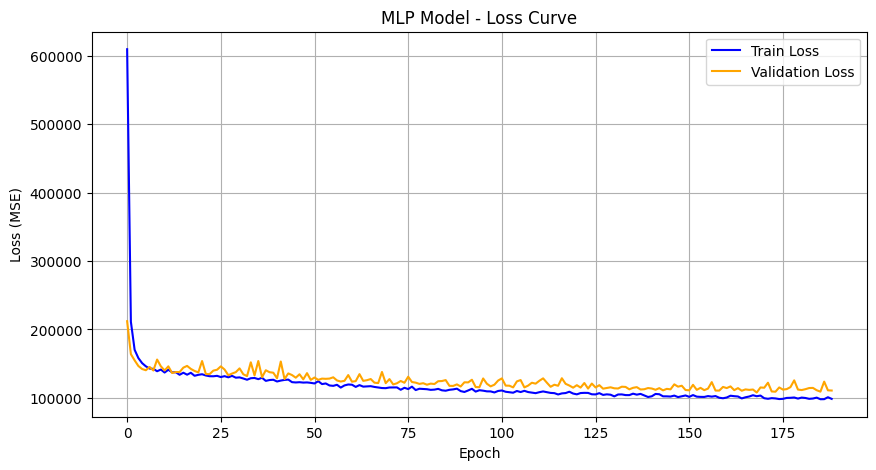

In [12]:
#Modelimizi eğittik ve sonuçları kaydettik. Şimdi eğittiğimiz modele hiç görmediği son hafta verilerini vererek sonuçları görselleştirelim.
# Burada sıklıkla tercih edilen MAE, RMSE ve MAPE değerlendirme ölçütlerini kullanalım.

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Tahmin
y_pred_mlp = mlp_model.predict(X_test_predict)

# Metrikler
mae_mlp = mean_absolute_error(y_test_predict, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test_predict, y_pred_mlp))
mape_mlp = mean_absolute_percentage_error(y_test_predict, y_pred_mlp)

print(f"Test RMSE: {rmse_mlp:.2f} TL")
print(f"Test MAE: {mae_mlp:.2f} TL")
print(f"Test MAPE: {mape_mlp*100:.2f}%")

import plotly.graph_objects as go
import pandas as pd

# 1) Tarihleri datetime ve tz-naive yap
dates_all = pd.to_datetime(df['date']).dt.tz_localize(None)

# 2) Test dilimine karşılık gelen tarihleri al (y_test_predict ile aynı uzunluk)
dates_test = dates_all.iloc[-len(y_test_predict):].to_numpy()

# 3) Vektörleri 1D float'a çevir
y_true = np.asarray(y_test_predict, dtype="float64").reshape(-1)
y_pred = np.asarray(y_pred_mlp, dtype="float64").reshape(-1)

# 4) Son 7 gün (168 saat)
n = min(168, len(y_true))
dates_plot = dates_test[-n:]
y_true_plot = y_true[-n:]
y_pred_plot = y_pred[-n:]

# 5) NaN/inf temizliği (boş çizgi sorunlarının başlıca sebebi)
mask = (
    (~np.isnan(y_true_plot)) & (~np.isnan(y_pred_plot)) &
    np.isfinite(y_true_plot) & np.isfinite(y_pred_plot) &
    (~pd.isna(dates_plot))
)
dates_plot = dates_plot[mask]
y_true_plot = y_true_plot[mask]
y_pred_plot = y_pred_plot[mask]

# (İstersen kontrol et)
print("Lengths:", len(dates_plot), len(y_true_plot), len(y_pred_plot))

# 6) Grafik
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_plot, y=y_true_plot, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=dates_plot, y=y_pred_plot, mode='lines', name='MLP Predict'))

fig.update_layout(
    title='📈 Last 7 Days Actual MCP vs MLP Prediction',
    xaxis_title='Date',
    yaxis_title='Price (TL)',
    legend=dict(x=0.01, y=0.99),
    font=dict(size=14),
    height=500,
    width=1000
)

# Metrikleri köşeye iliştir (opsiyonel)
fig.add_annotation(
    xref='paper', yref='paper', x=0.99, y=0.01, showarrow=False, align='right',
    text=f"RMSE: {rmse_mlp:.0f} TL<br>MAE: {mae_mlp:.0f} TL<br>MAPE: {mape_mlp*100:.2f}%"
)

fig.show()

loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('MLP Model - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Klasör olarak kaydetme
#Modeli kaydedeceğiz çünkü sonrasında tekrar çağırıp kullanabilir ayrıca her bir düğümde kullanılan değerler modelimizin güvenilirliği ve akademik açıdan bizim için önemli olacaktır.
#Genelde katman yapısını, kullandığımız nöron sayısını, öğrenme katsayısını, bias değerlerini ve ağırlıkları görmek isteyeceğiz.

mlp_model.save("my_mlp_model.keras")

In [14]:
from tensorflow.keras.models import load_model

# Modeli yükle
loaded_model = load_model("my_mlp_model.keras")

# Katman yapısı
loaded_model.summary()

# Ağırlık ve bias değerleri
weights = loaded_model.get_weights()
print(f"Toplam {len(weights)} ağırlık/bias matrisi yüklendi.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197 (47.65 KB)

 Trainable params: 4,065 (15.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,132 (31.77 KB)

Toplam 8 ağırlık/bias matrisi yüklendi.


In [15]:
def export_weights_biases(model, file_name="mlp_weights_biases.xlsx", max_values=10):
    """
    Modelin katmanlarındaki weights ve bias değerlerini tablo halinde kaydeder.

    Args:
        model: Keras modeli (Sequential veya Functional olabilir)
        file_name: Kaydedilecek Excel dosyası adı
        max_values: Her matristen gösterilecek maksimum değer (örnekleme)
    """
    wb_list = []

    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if weights:  # sadece Dense katmanlarda olur
            w, b = weights  # w: ağırlık matrisi, b: bias vektörü

            # İlk birkaç değeri tabloya ekleyelim (kurduğumuz modele göre bu değerler çok sayıda olabilir)
            wb_list.append({
                "Layer": f"Layer_{i}_weights",
                "Shape": w.shape,
                "Values (first few)": w.flatten()[:max_values]
            })
            wb_list.append({
                "Layer": f"Layer_{i}_biases",
                "Shape": b.shape,
                "Values (first few)": b.flatten()[:max_values]
            })

    # DataFrame'e çevir
    wb_df = pd.DataFrame(wb_list)

    # Excel'e kaydet
    wb_df.to_excel(file_name, index=False)
    print(f"✅ Ağırlık ve bias tablosu {file_name} dosyasına kaydedildi.")

    return wb_df

In [16]:
wb_df = export_weights_biases(mlp_model, "mlp_weights_biases.xlsx", max_values=10)
wb_df.head()

✅ Ağırlık ve bias tablosu mlp_weights_biases.xlsx dosyasına kaydedildi.


,Layer,Shape,Values (first few)
0,Layer_0_weights,"(13, 64)","[-0.2555465, 0.07002932, 0.22568896, 0.1533301..."
1,Layer_0_biases,"(64,)","[-0.0057684123, 0.0, 0.28324348, 0.21695702, 0..."
2,Layer_1_weights,"(64, 32)","[-0.056665722, -0.21637976, -0.0356189, -0.188..."
3,Layer_1_biases,"(32,)","[0.1746977, 0.0, 0.0, -0.031765778, 0.5177837,..."
4,Layer_2_weights,"(32, 32)","[0.046282195, 0.17300233, 0.22607166, -0.48685..."


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_test_predict = X[-168:]  # Son 168 satır
y_test_predict = y[-168:]

X_train_val = X[:-168]  # Son 168'den önceki tüm veriler
y_train_val = y[:-168]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_predict = X_test_predict.reshape((X_test_predict.shape[0], 1, X_test_predict.shape[1]))

# Modeli oluşturma
gru_model = Sequential()

# İlk GRU katmanı
gru_model.add(GRU(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# İkinci GRU katmanı
gru_model.add(GRU(units=32, activation='relu', return_sequences=False))

# Üçüncü GRU katmanı (Bu katmanı burada kullanmadık sizin verileriniz için değerlendirilebilir)
#model.add(GRU(units=64, activation='relu', return_sequences=True))

# Dördüncü GRU katmanı (Bu katmanı burada kullanmadık sizin verileriniz için değerlendirilebilir)
#model.add(GRU(units=64, activation='relu', return_sequences=True))

# Beşinci GRU katmanı (Bu katmanı burada kullanmadık sizin verileriniz için değerlendirilebilir)
#model.add(GRU(units=64, activation='relu'))

# Dropout (overfitting'i engellemek için)
gru_model.add(Dropout(0.02))

# Çıktı katmanı
gru_model.add(Dense(units=1))

# Modeli derleme
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stop = EarlyStopping(
    monitor='val_loss',          # İzlenen metrik
    patience=20,                 # 20 epoch boyunca iyileşme yoksa dur
    restore_best_weights=True   # En iyi ağırlıkları geri yükle
)

# Modeli özetle
gru_model.summary()

gru_history = gru_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],     # Erken durdurmayı ekledik
    verbose=1
)

# Modelin doğrulama kaybını inceleme
val_loss_gru = gru_history.history['val_loss']
print(f"Validation Loss: {val_loss_gru[-1]}")

# Test seti (son 168 satır) üzerinde değerlendirme
test_loss_gru = gru_model.evaluate(X_test_predict, y_test_predict)
print(f"Test Loss: {test_loss_gru}")

# Tahmin yapma
y_pred_gru = gru_model.predict(X_test_predict)

# Tahmin sonuçlarını yazdırma
print(f"Tahmin Sonuçları:\n {y_pred_gru[:24]}")  # İlk 24 tahmini göster

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Modelin test seti üzerinde tahmin yapma
y_pred_gru = gru_model.predict(X_test_predict)

# MAE, RMSE, MAPE hesaplama

# MAE (Mean Absolute Error)
mae_gru = mean_absolute_error(y_test_predict, y_pred_gru)
print(f"MAE (Mean Absolute Error): {mae_gru}")

# RMSE (Root Mean Squared Error)
rmse_gru = np.sqrt(mean_squared_error(y_test_predict, y_pred_gru))
print(f"RMSE (Root Mean Squared Error): {rmse_gru}")

# MAPE (Mean Absolute Percentage Error)
mape_gru = mean_absolute_percentage_error(y_test_predict, y_pred_gru)
print(f"MAPE (Mean Absolute Percentage Error): {mape_gru * 100}%")  # Yüzde olarak ifade edilir

# İsterseniz tahminlerin ilk birkaçını da yazdırabilirsiniz
print(f"Predictions (first 10) GRU: {y_pred_gru[:10]}")
print(f"Actual Values (first 10) GRU: {y_test_predict[:10]}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,609 (96.13 KB)

 Trainable params: 24,609 (96.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2466875.7500 - val_loss: 344983.9375
Epoch 2/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 350849.0625 - val_loss: 232474.6875
Epoch 3/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 263377.0938 - val_loss: 194059.9531
Epoch 4/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 227454.7344 - val_loss: 180294.4375
Epoch 5/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 212745.3438 - val_loss: 165205.9375
Epoch 6/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 203132.7656 - val_loss: 161270.9219
Epoch 7/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 206715.9844 - val_loss: 155545.5000
Epoch 8/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 202946.0781 - val_loss: 158194.0469
Epoch 9/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 200647.3594 - val_loss: 149964.0781
Epoch 10/500
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 191818.3906 - val_loss: 153229.0469
Epoch 11/500
181/181 ━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test RMSE: 227.78 TL
Test MAE: 183.31 TL
Test MAPE: 6.89%
Lengths: 168 168 168


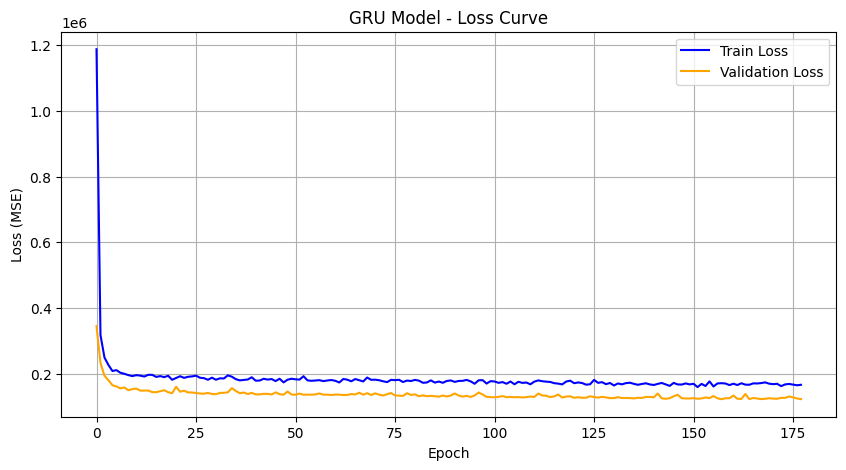

In [18]:
#Görselleştirme adımlarımız yine aynı şekilde devam edecek.
#Genel bir not: Bir kez import ettiğimiz kütüphaneyi aslında bir daha import etmemize lüzum yoktur.
#Burada anlatılan her bir kod bütününü ayrı ayrı sizlerin deneme yapabilme ihtimali bulunduğundan her seferinde yeniden ekliyorum. Dilerseniz fazlaca içe aktarma işlemini azaltabilirsiniz.

# Tahmin
y_pred_gru = gru_model.predict(X_test_predict)

# Metrikler
mae_gru = mean_absolute_error(y_test_predict, y_pred_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_predict, y_pred_gru))
mape_gru = mean_absolute_percentage_error(y_test_predict, y_pred_gru)

print(f"Test RMSE: {rmse_gru:.2f} TL")
print(f"Test MAE: {mae_gru:.2f} TL")
print(f"Test MAPE: {mape_gru*100:.2f}%")

import plotly.graph_objects as go
import pandas as pd

# 1) Tarihleri datetime ve tz-naive yap
dates_all = pd.to_datetime(df['date']).dt.tz_localize(None)

# 2) Test dilimine karşılık gelen tarihleri al (y_test_predict ile aynı uzunluk)
dates_test = dates_all.iloc[-len(y_test_predict):].to_numpy()

# 3) Vektörleri 1D float'a çevir
y_true = np.asarray(y_test_predict, dtype="float64").reshape(-1)
y_pred = np.asarray(y_pred_gru, dtype="float64").reshape(-1)

# 4) Son 7 gün (168 saat)
n = min(168, len(y_true))
dates_plot = dates_test[-n:]
y_true_plot = y_true[-n:]
y_pred_plot = y_pred[-n:]

# 5) NaN/inf temizliği (boş çizgi sorunlarının başlıca sebebi)
mask = (
    (~np.isnan(y_true_plot)) & (~np.isnan(y_pred_plot)) &
    np.isfinite(y_true_plot) & np.isfinite(y_pred_plot) &
    (~pd.isna(dates_plot))
)
dates_plot = dates_plot[mask]
y_true_plot = y_true_plot[mask]
y_pred_plot = y_pred_plot[mask]

# (İstersen kontrol et)
print("Lengths:", len(dates_plot), len(y_true_plot), len(y_pred_plot))

# 6) Grafik
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_plot, y=y_true_plot, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=dates_plot, y=y_pred_plot, mode='lines', name='GRU Predict'))

fig.update_layout(
    title='📈 Last 7 Days Actual MCP vs GRU Prediction',
    xaxis_title='Date',
    yaxis_title='Price (TL)',
    legend=dict(x=0.01, y=0.99),
    font=dict(size=14),
    height=500,
    width=1000
)

# Metrikleri köşeye iliştir (opsiyonel)
fig.add_annotation(
    xref='paper', yref='paper', x=0.99, y=0.01, showarrow=False, align='right',
    text=f"RMSE: {rmse_gru:.0f} TL<br>MAE: {mae_gru:.0f} TL<br>MAPE: {mape_gru*100:.2f}%"
)

fig.show()

loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('GRU Model - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Klasör olarak kaydetme
gru_model.save("my_gru_model.keras")

In [20]:
from tensorflow.keras.models import load_model

# Modeli yükle
loaded_model = load_model("my_gru_model.keras")

# Katman yapısı
loaded_model.summary()

# Ağırlık ve bias değerleri
weights = loaded_model.get_weights()
print(f"Toplam {len(weights)} ağırlık/bias matrisi yüklendi.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,829 (288.40 KB)

 Trainable params: 24,609 (96.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,220 (192.27 KB)

Toplam 8 ağırlık/bias matrisi yüklendi.


In [2]:
def export_weights_biases(model, file_name="gru_weights_biases.xlsx", max_values=10):
    """
    Modelin katmanlarındaki tüm weights ve biases değerlerini tablo halinde kaydeder.

    Args:
        model: Keras modeli (Sequential veya Functional olabilir)
        file_name: Kaydedilecek Excel dosyası adı
        max_values: Her matristen gösterilecek maksimum değer (örnekleme)
    """
    wb_list = []

    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if weights:
            for j, param in enumerate(weights):
                wb_list.append({
                    "Layer": f"Layer_{i}_param_{j}",
                    "Shape": param.shape,
                    "Values (first few)": param.flatten()[:max_values]
                })

    # DataFrame'e çevir
    wb_df = pd.DataFrame(wb_list)

    # Excel'e kaydet
    wb_df.to_excel(file_name, index=False)
    print(f"✅ Ağırlık ve bias tablosu '{file_name}' dosyasına kaydedildi.")

    return wb_df


In [22]:
wb_df = export_weights_biases(gru_model, "gru_weights_biases.xlsx", max_values=10)
wb_df.head()

✅ Ağırlık ve bias tablosu 'gru_weights_biases.xlsx' dosyasına kaydedildi.


,Layer,Shape,Values (first few)
0,Layer_0_param_0,"(13, 192)","[-0.010060057, 0.089022875, 0.11842373, -0.158..."
1,Layer_0_param_1,"(64, 192)","[0.022239804, -0.010147624, 0.00050039217, -0...."
2,Layer_0_param_2,"(2, 192)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Layer_1_param_0,"(64, 96)","[0.03475432, -0.182928, 0.020971462, 0.1003083..."
4,Layer_1_param_1,"(32, 96)","[0.13603008, 0.015121733, 0.11643425, -0.13302..."
